# Model expressivity

We plot ground truth dataset's relationship between acceleration and velocity difference.

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as functional
from torch.utils.data import random_split
from torch_geometric.data import Batch, Data, DataLoader

In [8]:
import os
import sys

script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env/gnn")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [30]:
from collab_env.data.boids.animal_simulation import visualize_graph, visualize_pair
from collab_env.gnn.gnn import (get_adjcency_from_debug, plot_log_loss, train_rules_gnn,
    identify_frames, find_frame_sets, load_model, debug_result2prediction)
from utility import handle_discrete_data
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.data.boids.animal_simulation import visualize_graph_2sets

In [10]:
dataset = torch.load(
    "/workspace/collab-environment/collab_env/data/boids/boid_single_species_basic.pt",
    weights_only=False,
)
species_configs = torch.load(
    "/workspace/collab-environment/collab_env/data/boids/boid_single_species_basic_config.pt",
    weights_only=False,
)

In [11]:
# split data into training set and test set
test_size = int(len(dataset) / 2)
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(2025)
)

In [12]:
# create mini-batches
batch_size = 1
# right now we assume the batch_size = 1, because our real dataset are of different lengths.
# But we can expand to minibatches - except fpr a few specific functions, every function is written with minibatches in mind.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

batch = list(iter(test_loader))[0]
pos, species = batch

print("made", str(len(list(test_loader))), "batches, each of size", str(batch_size))  #
print(
    "Batch position:", pos.shape
)  # [Batch size, Number of boids, coordinates (x,y pos)= 2]
print("Species labels:", species.shape)  # [B, N]
print("\n")

made 25 batches, each of size 1
Batch position: torch.Size([1, 1000, 20, 2])
Species labels: torch.Size([1, 20])




/workspace/conda/envs/gnn/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [36]:
# load various models
models = {}

# model 1
old_name = "vpluspplus_a"
new_name = "no noise"
model_path = f"/workspace/collab-environment/collab_env/gnn/trained_models/boid_single_species_{old_name}_basic_special_frames.pt"
model = load_model(new_name, model_path)
models[new_name] = model

In [82]:
# model 2
old_name = "vpluspplus_a"
new_name = "noise = 0.001"
model_path = f"/workspace/collab-environment/collab_env/gnn/trained_models/boid_single_species_{old_name}_basic_noise_0.001_specialframes.pt"
model = load_model(new_name, model_path)
models[new_name] = model

In [ ]:
# model 3
old_name = "vpluspplus_a"
new_name = "noise = 0.005"
model_path = f"/workspace/collab-environment/collab_env/gnn/trained_models/boid_single_species_{old_name}_basic_noise_0.001_specialframes.pt"
model = load_model(new_name, model_path)
models[new_name] = model

In [83]:
# do rollout
torch.cuda.empty_cache()

In [84]:
dataloader_list = list(test_loader)
visual_range = 0.5

In [99]:
training = False
epoch_num = 1
lr = None
rollout = 5
prediction_integration = "Euler"

for model_names in ["no noise"]: #models:
    m = models[model_names]

    (
        node_feature_function,
        node_prediction,
        input_differentiation,
        prediction_integration,
        in_node_dim,
        start_frame,
    ) = (
        m["node_feature_function"],
        m["node_prediction"],
        m["input_differentiation"],
        prediction_integration,
        m["in_node_dim"],
        m["start_frame"],
    )

    gnn_model = m["model"]

    # train models
    (m["rollout_losses"], _, m["rollout_debug_result"]) = train_rules_gnn(
        gnn_model,
        test_loader,
        visual_range=visual_range,
        epochs=epoch_num,
        lr=lr,
        training=training,
        species_dim=len(torch.unique(species)),
        device=None,
        rollout = rollout,
    )

    m["rollout_W_input"], m["rollout_W_output"] = get_adjcency_from_debug(
        m["rollout_debug_result"], test_loader, visual_range
    )

epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 2816395.5429
finished one epoch


In [100]:
file_id = 3

model_name = "no noise"#"noise = 0.001"
m = models[model_name]
rollout_debug_result = m["rollout_debug_result"]
pos, vel, acc, pos_gnn, vel_gnn, acc_gnn, frame_sets = debug_result2prediction(
                        m["rollout_debug_result"],
                        file_id = file_id, epoch_num = 0)

/tmp/ipykernel_50702/170444599.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


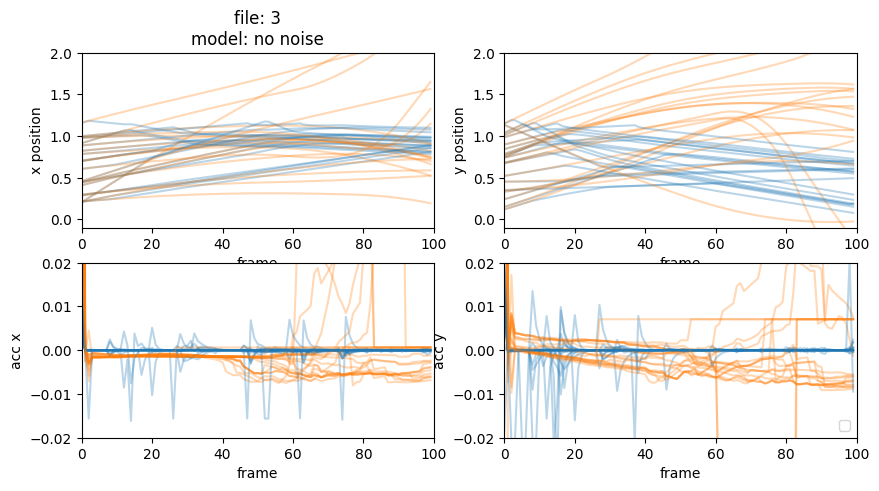

In [101]:
%matplotlib inline

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax = ax.ravel()
alpha = 0.3

stop_frame = 100

for b in np.arange(20):

    ax[0].plot(pos[0, :stop_frame, b, 0] + 0.01 * b, color = 'C0', alpha = alpha)
    ax[0].plot(pos_gnn[0, :stop_frame, b, 0] + 0.01 * b, color = 'C1', alpha = alpha)
    ax[0].set_title("file: "+str(file_id) + "\nmodel: " + model_name)
    
    
    ax[1].plot(pos[0, :stop_frame, b, 1] + 0.01 * b, color = 'C0', alpha = alpha)
    ax[1].plot(pos_gnn[0, :stop_frame, b, 1] + 0.01 * b, color = 'C1', alpha = alpha)

    
    ax[2].plot(acc[0, :stop_frame, b, 0], color = 'C0', alpha = alpha)
    ax[2].plot(acc_gnn[0, :stop_frame, b, 0]* 20, color = 'C1', alpha = alpha)
    
    
    ax[3].plot(acc[0, :stop_frame, b, 1], color = 'C0', alpha = alpha)
    ax[3].plot(acc_gnn[0, :stop_frame, b, 1]* 20, color = 'C1', alpha = alpha)

ax[0].set_xlabel("frame")
ax[0].set_ylabel("x position")
ax[0].set_ylim([-0.1,2])

ax[1].set_xlabel("frame")
ax[1].set_ylabel("y position")
ax[1].set_ylim([-0.1,2])

ax[2].set_xlabel("frame")
ax[2].set_ylabel("acc x")
ax[2].set_ylim([-0.02,0.02])

#ax[3].plot(loss_acc, label="acc loss")
ax[3].set_xlabel("frame")
ax[3].set_ylabel("acc y")
ax[3].set_ylim([-0.02,0.02])


ax[0].set_xlim([0, stop_frame])
ax[1].set_xlim([0, stop_frame])
ax[2].set_xlim([0, stop_frame])
ax[3].set_xlim([0, stop_frame])

plt.legend()
plt.show()

p0 shape torch.Size([20, 2])
p shape torch.Size([996, 20, 2])


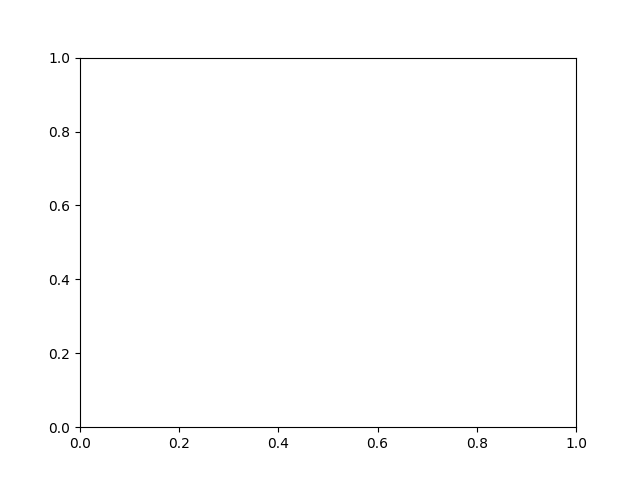

In [92]:
%matplotlib widget

ani, ax = visualize_graph_2sets(pos[0], vel[0], pos_gnn[0], vel_gnn[0],
                starting_frame = 0, ending_frame = 100,
                file_id = 0)